In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KernelDensity

In [12]:
%matplotlib inline

## Load and visualize the data points

In [76]:
points = pd.read_csv("spiral1.txt")

In [77]:
points.head(3)

,x,y
0,8,14
1,8,15
2,8,16


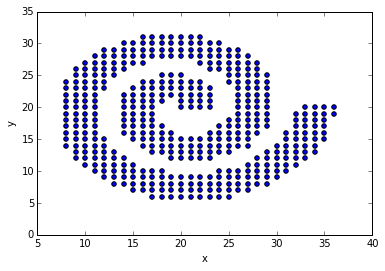

In [67]:
points.plot(kind='scatter', x='x', y='y')

In [101]:
h = 0.2

In [116]:
num_points = 20

In [118]:
x = np.linspace(0, 40, num_points)
y = np.linspace(0, 40, num_points)

In [117]:
b = np.zeros([num_points, num_points])

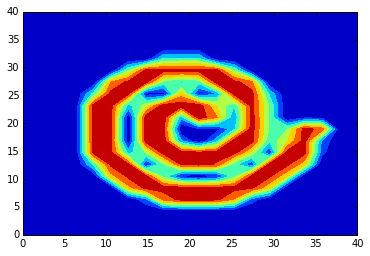

In [122]:
for i in range(num_points):
    for j in range(num_points):
        b[i, j] = estimate_density(i, j, points, 0.5)
H = plt.contourf(x,y,b)

In [103]:
def l2_distance(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

In [121]:
def estimate_density(i, j, points, h):
    val = 0
    n = len(points.index)
    for index, pt in points.iterrows():
        dist = l2_distance((x[j], y[i]), (pt))
        val += 1 / (n * h) * density_of_normal(dist, h)
    return val

In [102]:
bandwidthdef density_of_normal(d, h):
    result = 1 / ((2 * np.pi) ** 0.5 * h) * np.exp(- d ** 2 / (2 * h ** 2))
    return result